In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import os


# 1. Load FAO Food Price Index (FPI)

fao_path = "./Food_price_indices_data_may629 (2).xls"  # Replace with your path
fao_df = pd.read_excel(fao_path, sheet_name=0, skiprows=2)

# Keep only columns that are not 'Unnamed'
fao_columns = [c for c in fao_df.columns if 'Unnamed' not in c]
fao_df = fao_df[fao_columns]

# Melt to long format
fao_long = fao_df.melt(
    id_vars=['Date'],
    var_name='Commodity',
    value_name='FPI'
)

# Add Year and Month
fao_long['Year'] = fao_long['Date'].dt.year
fao_long['Month'] = fao_long['Date'].dt.month

print("FAO FPI long shape:", fao_long.shape)
fao_long.head()

# 2. Load FAO monthly Food CPI (.dta)

fcpi_path = "./Inflation-data/fcpi_m.dta"  # Replace with your path
fcpi_df = pd.read_stata(fcpi_path)

# Keep only Country + numeric monthly columns (ignore _Note)
fcpi_df = fcpi_df[['Country'] + [c for c in fcpi_df.columns if c.startswith('_') and c[1:].isdigit()]]

# Melt wide to long
fcpi_long = fcpi_df.melt(
    id_vars=['Country'],
    var_name='YearMonth',
    value_name='Food_CPI'
)

# Convert YearMonth to datetime
fcpi_long['YearMonth'] = fcpi_long['YearMonth'].str.replace('_','')
fcpi_long['Date'] = pd.to_datetime(fcpi_long['YearMonth'], format='%Y%m')
fcpi_long['Year'] = fcpi_long['Date'].dt.year
fcpi_long['Month'] = fcpi_long['Date'].dt.month
fcpi_long.drop(columns=['YearMonth'], inplace=True)

print("FAO Food CPI long shape:", fcpi_long.shape)
fcpi_long.head()


# 3. Load World Bank CPI

cpi_path = "./API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_23195 (1)/API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_23195.csv"
cpi_df = pd.read_csv(cpi_path, skiprows=4)

# Melt wide to long
cpi_long = cpi_df.melt(
    id_vars=['Country Name','Country Code','Indicator Name','Indicator Code'],
    var_name='Year',
    value_name='CPI'
)

# Keep only numeric years
cpi_long = cpi_long[cpi_long['Year'].str.isnumeric()]
cpi_long['Year'] = cpi_long['Year'].astype(int)
cpi_long.dropna(subset=['CPI'], inplace=True)

print("World Bank CPI long shape:", cpi_long.shape)
cpi_long.head()


# 4. Load World Bank GDP Deflator

gdp_path = "./API_NY.GDP.DEFL.KD.ZG_DS2_en_csv_v2_22672 (1)/API_NY.GDP.DEFL.KD.ZG_DS2_en_csv_v2_22672.csv"
gdp_df = pd.read_csv(gdp_path, skiprows=4)

# Melt wide to long
gdp_long = gdp_df.melt(
    id_vars=['Country Name','Country Code','Indicator Name','Indicator Code'],
    var_name='Year',
    value_name='GDP_Deflator'
)

# Keep only numeric years
gdp_long = gdp_long[gdp_long['Year'].str.isnumeric()]
gdp_long['Year'] = gdp_long['Year'].astype(int)
gdp_long.dropna(subset=['GDP_Deflator'], inplace=True)

print("World Bank GDP Deflator long shape:", gdp_long.shape)
gdp_long.head()


# 5. Merge datasets

# Merge FAO FPI with FAO CPI on Year and Month
merged = pd.merge(
    fao_long,
    fcpi_long[['Country','Year','Month','Food_CPI']],
    on=['Year','Month'],
    how='left'
)

# Merge with World Bank CPI on Year
merged = pd.merge(
    merged,
    cpi_long[['Country Name','Year','CPI']],
    left_on=['Country','Year'],
    right_on=['Country Name','Year'],
    how='left'
)

# Merge with GDP Deflator on Year
merged = pd.merge(
    merged,
    gdp_long[['Country Name','Year','GDP_Deflator']],
    left_on=['Country','Year'],
    right_on=['Country Name','Year'],
    how='left'
)

# Drop redundant columns
merged.drop(columns=['Country Name_x','Country Name_y'], inplace=True, errors='ignore')

print("Merged dataset shape:", merged.shape)
merged.head()


FAO FPI long shape: (2334, 5)
FAO Food CPI long shape: (113373, 5)
World Bank CPI long shape: (6284, 6)
World Bank GDP Deflator long shape: (14019, 6)
Merged dataset shape: (398094, 9)


,Date,Commodity,FPI,Year,Month,Country,Food_CPI,CPI,GDP_Deflator
0,NaT,Food Price Index,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Austria,59.46581,3.261872,2.999681
2,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Belgium,NaN,3.448312,2.812404
3,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Canada,57.93543,4.780477,3.352302
4,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Chile,NaN,26.036481,22.553700


FAO FPI (Food Price Index)

.Tracks global food prices for different commodities (like sugar, wheat, rice).

.Helps see how the price of each food item changes worldwide over time.

FAO Food_CPI (Food Consumer Price Index)

.Tracks food prices that people actually pay in each country.

.Shows how food inflation differs from country to country.

World Bank CPI (Consumer Price Index)

.Tracks overall price changes for all goods and services in a country.

.Lets you compare food price changes vs general inflation.

World Bank GDP Deflator

.Measures inflation for all goods and services produced in a country.


In [40]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398094 entries, 0 to 398093
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          398088 non-null  datetime64[ns]
 1   Commodity     398094 non-null  object        
 2   FPI           398088 non-null  float64       
 3   Year          398088 non-null  float64       
 4   Month         398088 non-null  float64       
 5   Country       398088 non-null  object        
 6   Food_CPI      209028 non-null  float64       
 7   CPI           207480 non-null  float64       
 8   GDP_Deflator  326976 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 27.3+ MB


FAO FPI – Global commodity-level food prices (monthly)
 Shows how global food prices change, per commodity.

FAO Food_CPI – Country-level food price index (monthly)
 Shows how food prices paid by consumers in each country change over time.

World Bank CPI – Country-level overall consumer price index (annual)
 Lets you compare food-specific inflation vs general inflation.

World Bank GDP Deflator – Country-level inflation of all goods/services (annual)
 Can be used as another measure of inflation and economic context.

In [41]:
merged.isnull().sum()

Date                 6
Commodity            0
FPI                  6
Year                 6
Month                6
Country              6
Food_CPI        189066
CPI             190614
GDP_Deflator     71118
dtype: int64

In [42]:
merged.head()

,Date,Commodity,FPI,Year,Month,Country,Food_CPI,CPI,GDP_Deflator
0,NaT,Food Price Index,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Austria,59.46581,3.261872,2.999681
2,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Belgium,NaN,3.448312,2.812404
3,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Canada,57.93543,4.780477,3.352302
4,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Chile,NaN,26.036481,22.553700


In [43]:
merged.tail()

,Date,Commodity,FPI,Year,Month,Country,Food_CPI,CPI,GDP_Deflator
398089,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN
398090,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN
398091,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN
398092,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN
398093,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN


In [55]:

# Count of unique countries
num_countries = merged['Country'].nunique()
print("Number of unique countries:", num_countries)

Number of unique countries: 152


In [56]:
# List all unique countries
unique_countries = merged['Country'].unique()
print("Countries in dataset:", unique_countries)


Countries in dataset: [nan 'Austria' 'Belgium' 'Canada' 'Chile' 'China' 'Colombia'
 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Korea, Rep.' 'Latvia' 'Lithuania' 'Luxembourg' 'Mexico' 'Netherlands'
 'Norway' 'Poland' 'Portugal' 'Saudi Arabia' 'Slovakia' 'Slovenia'
 'South Africa' 'Spain' 'Sweden' 'Switzerland' 'Turkey' 'United Kingdom'
 'United States' 'Angola' 'Brazil' 'Costa Rica' 'Ghana' 'India'
 'Indonesia' 'Jamaica' 'Kenya' 'Maldives' 'Malta' 'Myanmar' 'Panama'
 'Philippines' 'Puerto Rico' 'Romania' 'Russian Federation' 'Singapore'
 'Sri Lanka' 'Suriname' 'Taiwan, China' 'Tanzania, United Rep.' 'Thailand'
 'Uganda' 'United Arab Emirates' 'Uruguay' 'Venezuela, RB' 'Afghanistan'
 'Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belize' 'Benin'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana'
 'Brunei Darussalam' 'Bu

In [57]:
# Filter dataset for Kenya
kenya_data = merged[merged['Country'] == 'Kenya']

# Show first few rows
display(kenya_data.head())

# Number of rows for Kenya
print("Number of rows for Kenya:", len(kenya_data))


,Date,Commodity,FPI,Year,Month,Country,Food_CPI,CPI,GDP_Deflator
46,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Kenya,NaN,NaN,10.637199
217,1990-02-01,Food Price Index,64.453560,1990.0,2.0,Kenya,NaN,NaN,10.637199
388,1990-03-01,Food Price Index,63.787064,1990.0,3.0,Kenya,NaN,NaN,10.637199
559,1990-04-01,Food Price Index,65.766754,1990.0,4.0,Kenya,NaN,NaN,10.637199
730,1990-05-01,Food Price Index,64.378874,1990.0,5.0,Kenya,NaN,NaN,10.637199


Number of rows for Kenya: 2328


# EDA

In [ ]:
# 1. Numerical features

numerical_cols = ['FPI', 'Food_CPI', 'CPI', 'GDP_Deflator']
eda_df = merged[numerical_cols].copy()

In [ ]:
# Set plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12,6)

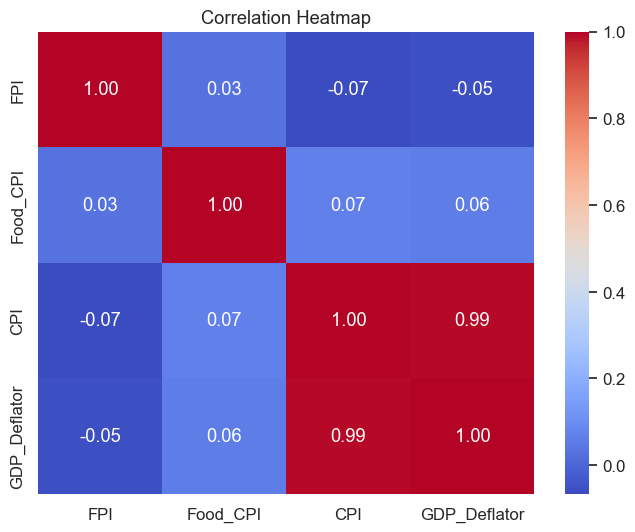

In [ ]:
# 2. Heatmap of correlations

plt.figure(figsize=(8,6))
corr = eda_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Extreme Multicollinearity: The correlation of r=0.99 between the CPI and the GDP_Deflator indicates near-perfect multicollinearity.

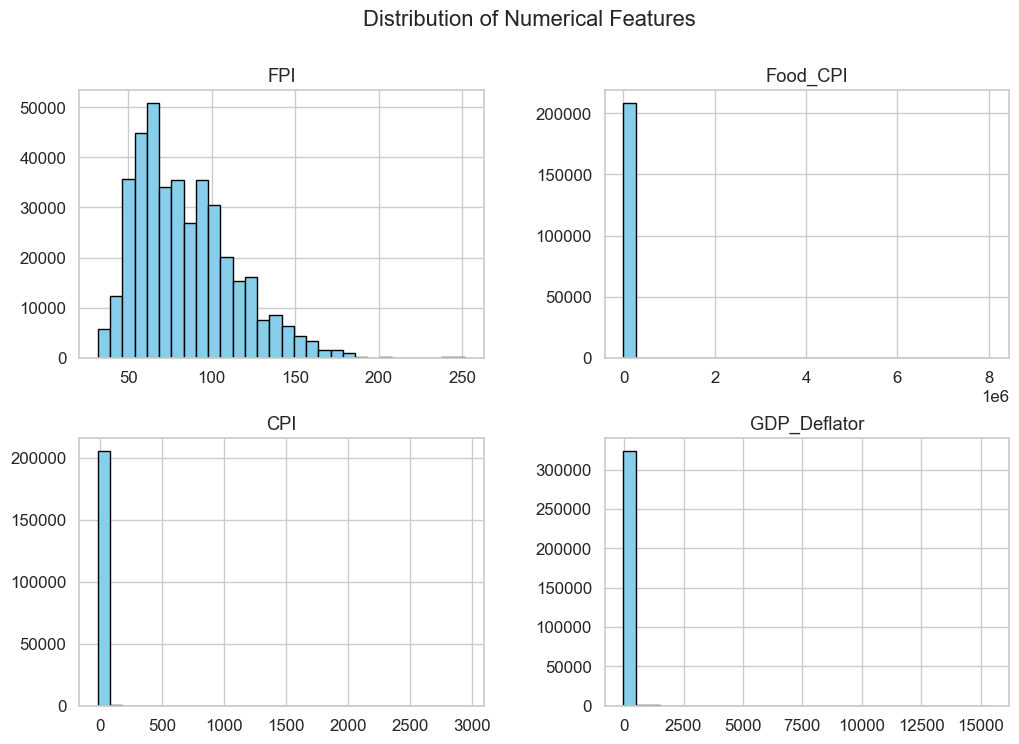

In [ ]:
# 3. Histograms 

eda_df.hist(bins=30, figsize=(12,8), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Numerical Features")
plt.show()

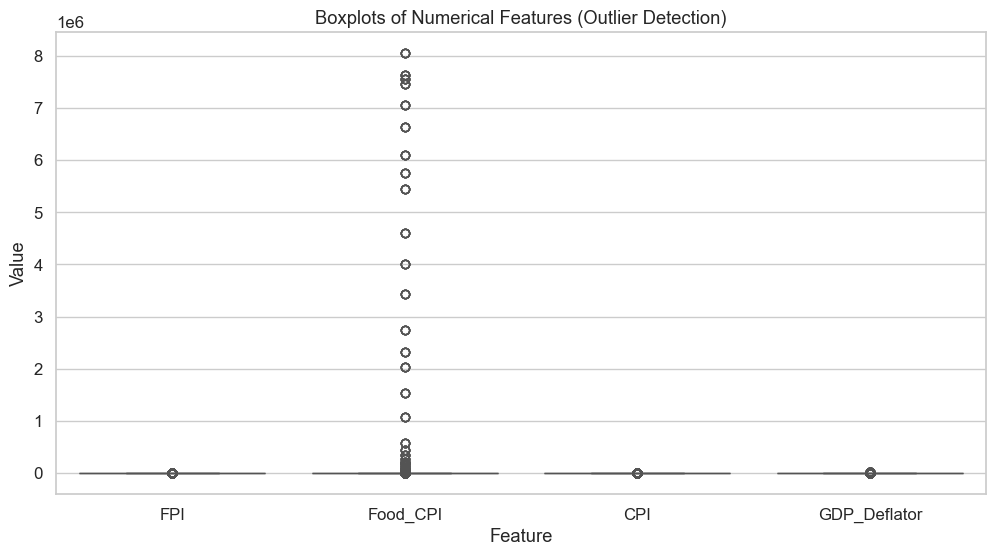

In [ ]:
# 4. Boxplots for outliers

plt.figure(figsize=(12,6))
eda_df_melt = eda_df.melt(var_name='Feature', value_name='Value')
sns.boxplot(x='Feature', y='Value', data=eda_df_melt)
plt.title("Boxplots of Numerical Features (Outlier Detection)")
plt.show()

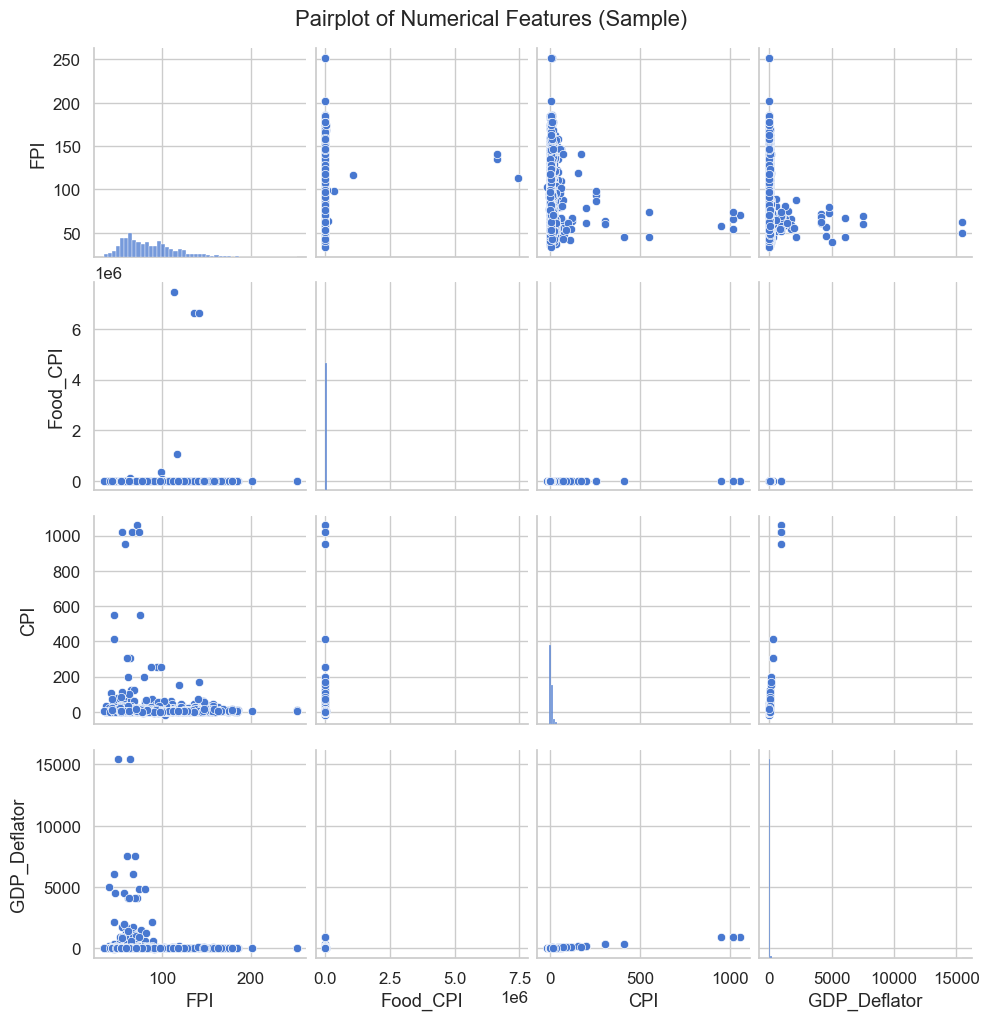

In [ ]:
# 5. Pairplot (sample for performance)

sample_df = eda_df.sample(n=5000, random_state=42)  # sample to speed up plotting
sns.pairplot(sample_df)
plt.suptitle("Pairplot of Numerical Features (Sample)", y=1.02)
plt.show()

CPI vs. GDP_Deflator (Inferred from r=0.99)	Points lie tightly along a straight, upward line.	Highly Linear

FPI vs. CPI	Scattered vertically, no discernible straight line pattern.	Non-Linear

FPI vs. GDP_Deflator	Scattered vertically, no discernible straight line pattern.	Non-Linear

Food_CPI vs. All Others	Dominated by clustering near zero and extreme outliers.	Non-Linear

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate per year & commodity
agg = merged.groupby(['Year','Commodity']).agg({
    'FPI':'mean',
    'Food_CPI':'mean',
    'CPI':'mean'
}).reset_index()


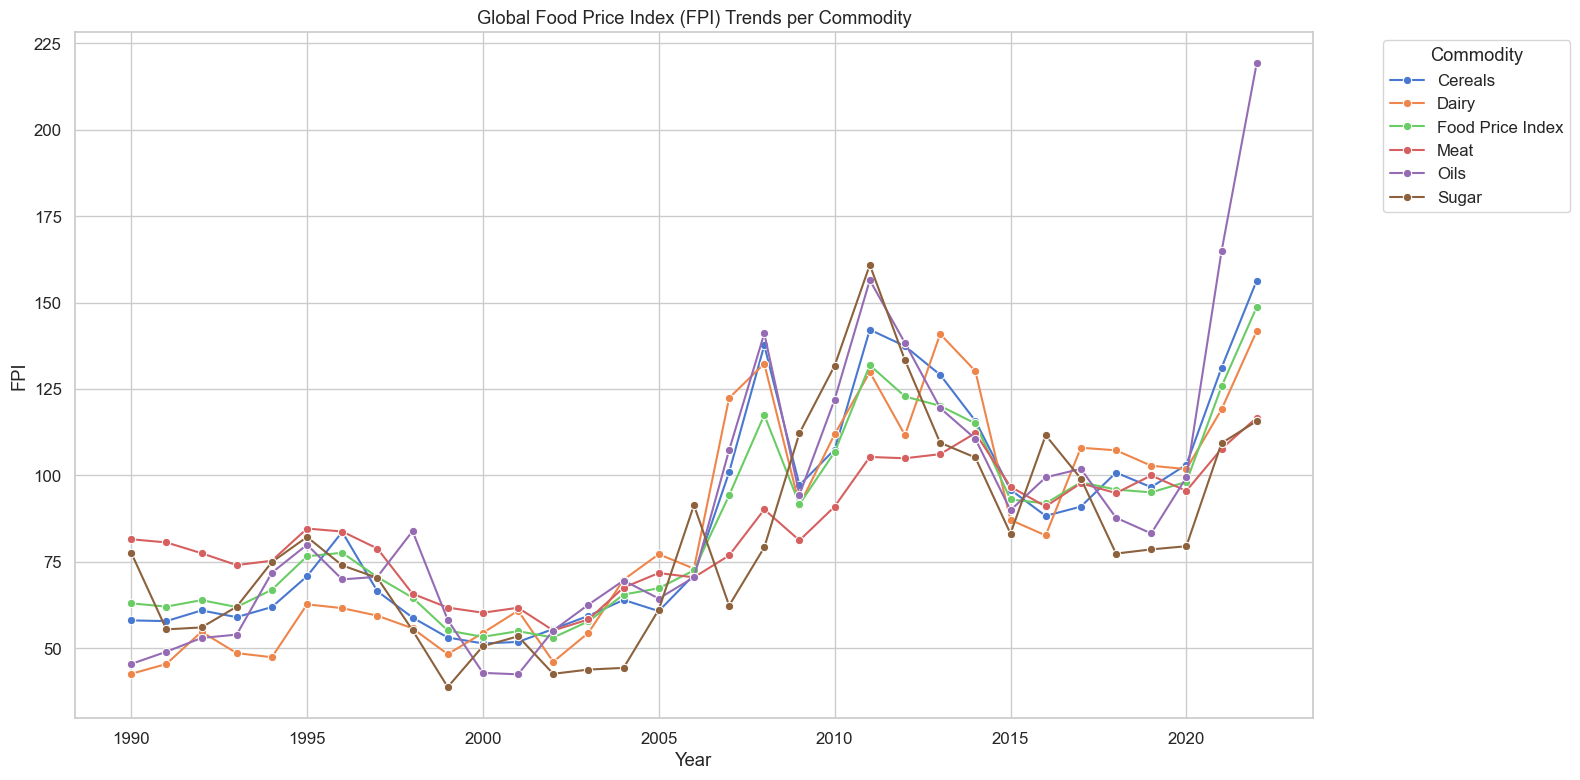

In [67]:
# Plot FPI trends per commodity
plt.figure(figsize=(16,8))
sns.lineplot(data=agg, x='Year', y='FPI', hue='Commodity', marker='o')
plt.title('Global Food Price Index (FPI) Trends per Commodity')
plt.ylabel('FPI')
plt.xlabel('Year')
plt.legend(title='Commodity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

From 1990 to 2005, the FPI was stable and low, generally between 50 and 75.

A first major price spike occurred between 2007 and 2012, pushing most FPIs past 100.

Prices then remained volatile and higher (75-125) from 2012 until 2020.

A recent, dramatic surge began after 2020, driving several commodities to record high FPI values

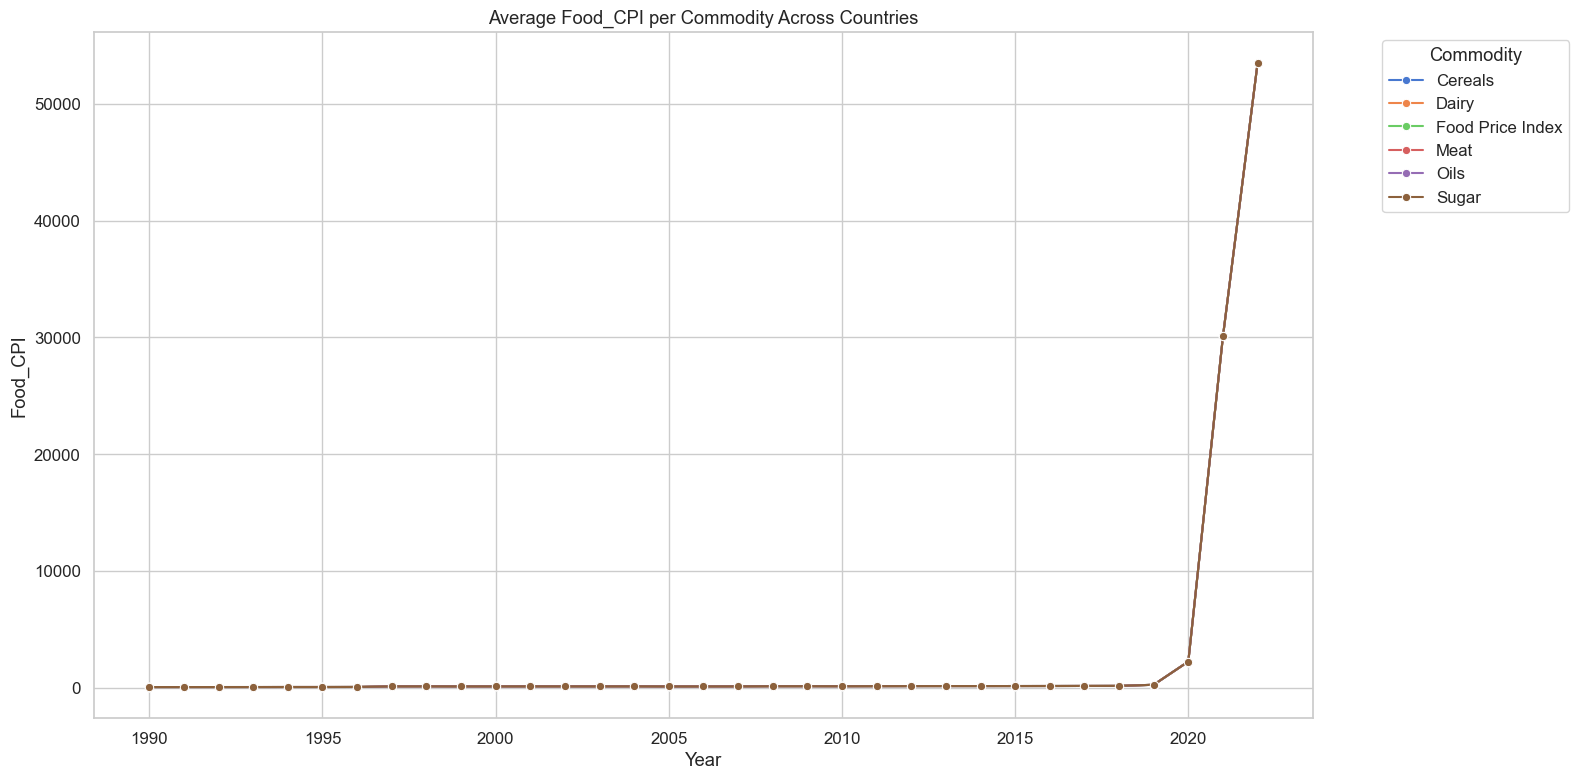

In [66]:
#  plot Food_CPI and CPI per commodity (only for countries with Food_CPI)
plt.figure(figsize=(16,8))
sns.lineplot(data=agg, x='Year', y='Food_CPI', hue='Commodity', marker='o')
plt.title('Average Food_CPI per Commodity Across Countries')
plt.ylabel('Food_CPI')
plt.xlabel('Year')
plt.legend(title='Commodity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


sudden acceleration of the average food consumer price index across countries, concentrated entirely in the period after 2020.

From 1990 to 2005, the FPI was stable and low, generally between 50 and 75.

A first major price spike occurred between 2007 and 2012, pushing most FPIs past 100.

Prices then remained volatile and higher (75-125) from 2012 until 2020.

A recent, dramatic surge began after 2020, driving several commodities to record high FPI values.

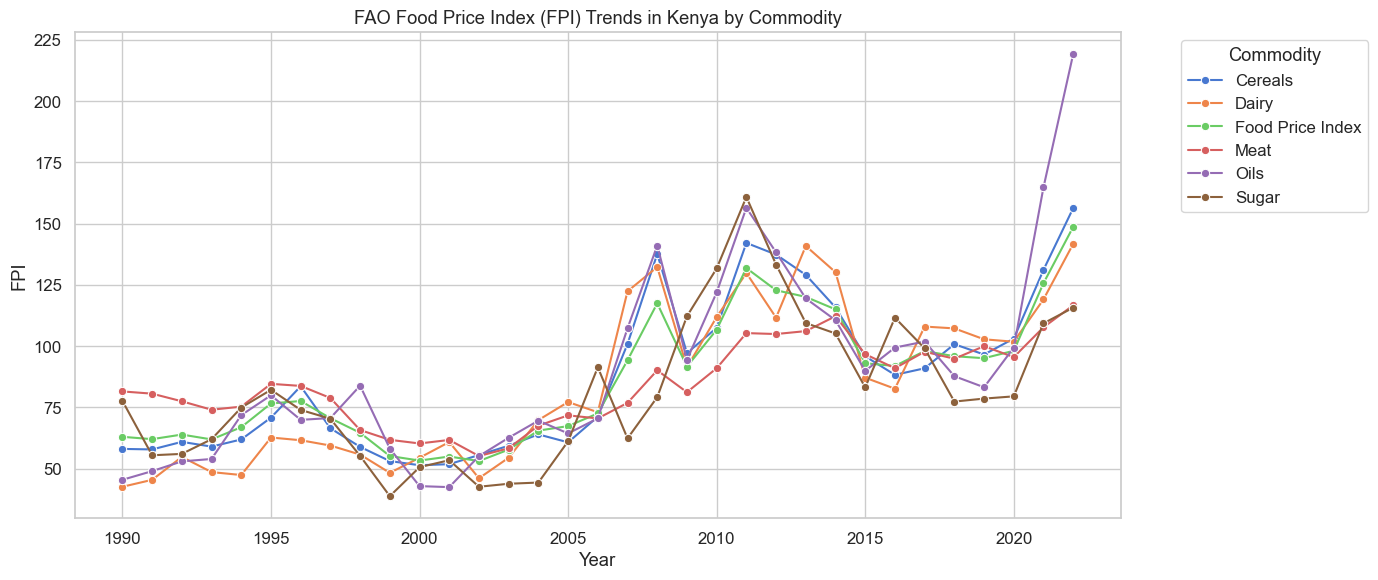

In [58]:
# Filter for Kenya
kenya_data = merged[merged['Country'] == 'Kenya']

# Aggregate by Year and Commodity for FPI
fpi_trends = kenya_data.groupby(['Year','Commodity'])['FPI'].mean().reset_index()

# Plot FPI trends
plt.figure(figsize=(14,6))
sns.lineplot(data=fpi_trends, x='Year', y='FPI', hue='Commodity', marker='o')
plt.title("FAO Food Price Index (FPI) Trends in Kenya by Commodity")
plt.xlabel("Year")
plt.ylabel("FPI")
plt.legend(title='Commodity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

From 1990 to 2005, the FPI was stable and low, generally between 50 and 75.

A first major price spike occurred between 2007 and 2012, pushing most FPIs past 100.

Prices then remained volatile and higher (75-125) from 2012 until 2020.

A recent, dramatic surge began after 2020, driving several commodities to record high FPI values.

In [61]:
from statsmodels.tsa.stattools import adfuller

# Aggregate globally per year
global_fpi = merged.groupby('Year')['FPI'].mean().dropna()

# ADF Test
adf_result = adfuller(global_fpi)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

if adf_result[1] < 0.05:
    print("Result: Data is likely stationary ")
else:
    print("Result: Data is likely non-stationary ")


ADF Statistic: 0.8921954118819269
p-value: 0.9929876243917356
Critical Values: {'1%': np.float64(-3.7529275211638033), '5%': np.float64(-2.998499866852963), '10%': np.float64(-2.6389669754253307)}
Result: Data is likely non-stationary 


<Figure size 1200x400 with 0 Axes>

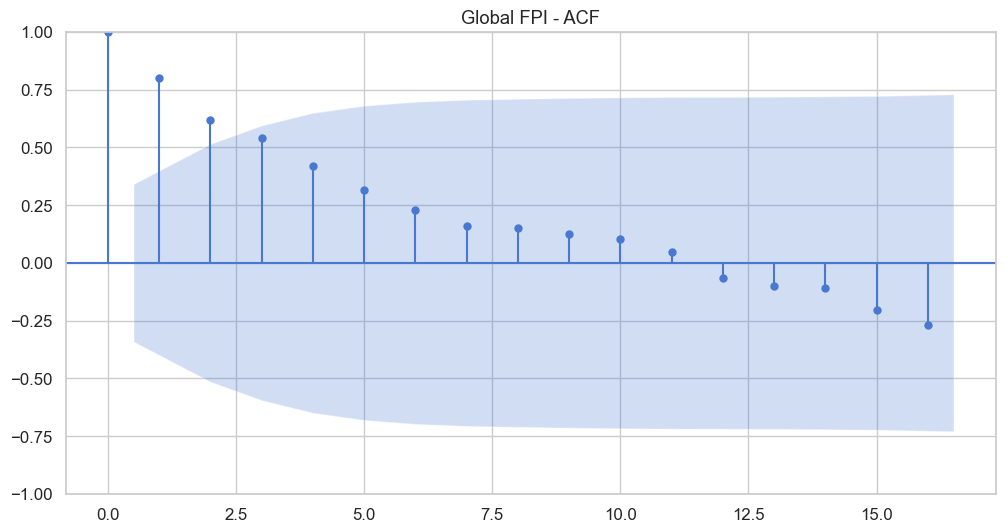

<Figure size 1200x400 with 0 Axes>

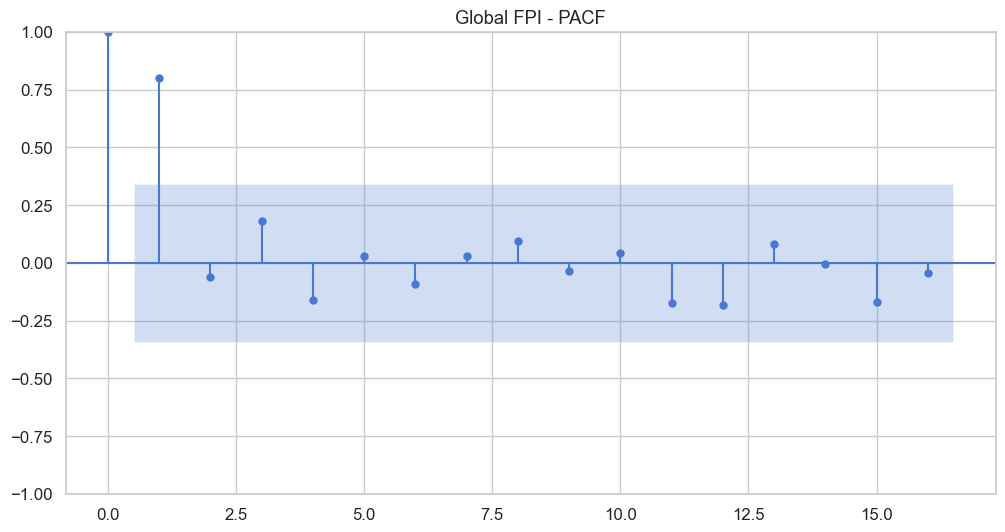

In [64]:
# ACF plot
plt.figure(figsize=(12,4))
plot_acf(global_fpi, lags=max_lags)
plt.title("Global FPI - ACF")
plt.show()

# PACF plot
plt.figure(figsize=(12,4))
plot_pacf(global_fpi, lags=max_lags, method='ywm')
plt.title("Global FPI - PACF")
plt.show()